# Mask to BEV

## Libraries

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from datasets import load_dataset
from PIL import Image
from scipy.stats import linregress

## Load saved masks

In [9]:
def load_predicted_masks(mask_dir):
    mask_files = sorted(f for f in os.listdir(mask_dir) if f.endswith(".npy"))
    masks = [np.load(os.path.join(mask_dir, f)) for f in mask_files]
    return masks

pred_masks = {
    "train": load_predicted_masks("predicted_masks/train"),
    "val": load_predicted_masks("predicted_masks/val")
}

## Load dataset

In [10]:
ds = load_dataset("Wilbur1240/MaSTr1325_512x384", split="train")
raw_splits = ds.train_test_split(test_size=0.1, seed=42)
raw_train_dataset = raw_splits["train"]
raw_valid_dataset = raw_splits["test"]
ds = {
    "train": raw_train_dataset,
    "val": raw_valid_dataset,
}
color_map = [
    (0, 255, 0),      # sea
    (0, 0, 255),      # obstacle
    (255, 0, 0),      # sky
    (0, 0, 0)         # background / ignored
]

In [11]:
pred_masks

{'train': [array([[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]]),
  array([[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]]),
  array([[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]]),
  array([[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]]),
  array([[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         

## IPM visualize

In [16]:
def get_ipm_homography(
    src_size=(512, 512),
    dst_size=(512, 512),
    fov_deg=100,
    cam_height=2.0,
    tilt_deg=60
):
    """
    Compute homography for IPM projection to ground plane (y=0).
    """
    H, W = src_size
    dst_H, dst_W = dst_size

    # Intrinsics
    f = (W/2) / np.tan(np.radians(fov_deg/2))
    cx, cy = W / 2, H / 2
    K = np.array([[f, 0, cx],
                  [0, f, cy],
                  [0, 0, 1]])

    K_inv = np.linalg.inv(K)

    # Rotation matrix (camera tilted down by tilt_deg degrees)
    tilt_rad = np.radians(tilt_deg)
    R = np.array([
        [1, 0,            0],
        [0, np.cos(tilt_rad), -np.sin(tilt_rad)],
        [0, np.sin(tilt_rad),  np.cos(tilt_rad)],
    ])

    # Ground plane normal (Z=0 world)
    n = np.array([[0], [1], [0]])  # up direction in world frame
    d = cam_height

    # Compute homography H = K * (R - (T n^T) / d) * K^-1
    T = np.array([[0], [-d], [0]])  # camera height in world coords
    H_ipm = K @ (R - (T @ n.T) / d) @ K_inv

    return H_ipm

def get_pitch_from_imu(imu_img, vertical_fov_deg=80):
    """Estimate pitch angle from binary IMU image."""
    if imu_img.ndim == 3:
        gray = cv2.cvtColor(imu_img, cv2.COLOR_RGB2GRAY)
    else:
        gray = imu_img  # already grayscale
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    horizon_rows = []
    for col in range(binary.shape[1]):
        col_vals = binary[:, col]
        edge_idx = np.argmax(col_vals == 255)
        horizon_rows.append(edge_idx)
    
    pixels_from_center = np.mean(horizon_rows) - (binary.shape[0] / 2)
    angle_per_pixel = vertical_fov_deg / binary.shape[0]
    pitch_deg = -pixels_from_center * angle_per_pixel
    return np.radians(pitch_deg)

def draw_grid(img, spacing=50, color=(255, 0, 0)):
    if not isinstance(img, np.ndarray):
        img = np.array(img.convert("RGB"))  # Convert to NumPy RGB array

    grid_img = img.copy()
    for x in range(0, grid_img.shape[1], spacing):
        cv2.line(grid_img, (x, 0), (x, grid_img.shape[0]), color, 1)
    for y in range(0, grid_img.shape[0], spacing):
        cv2.line(grid_img, (0, y), (grid_img.shape[1], y), color, 1)

    return grid_img

def warp_ipm(image, homography, dst_size=(512, 512)):
    return cv2.warpPerspective(image, homography, (dst_size[1], dst_size[0]), flags=cv2.INTER_NEAREST)

def visualize_ipm(raw_image, pred_mask, imu_img=None, color_map=None, fov_deg=150, cam_height=1.0, default_pitch=40):
    # Convert raw image if it's PIL or Tensor
    if not isinstance(raw_image, np.ndarray):
        raw_image = np.array(raw_image.convert("RGB"))

    if color_map is not None:
        color_mask = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
        for idx, color in enumerate(color_map):
            color_mask[pred_mask == idx] = color
    else:
        color_mask = pred_mask.astype(np.uint8) * 80  # grayscale fallback

    if imu_img is not None:
        pitch_deg = get_pitch_from_imu(imu_img)
    else:
        pitch_deg = default_pitch

    # Homography
    H_ipm = get_ipm_homography(
        src_size=raw_image.shape[:2],
        dst_size=(512, 512),
        fov_deg=fov_deg,
        cam_height=cam_height,
        tilt_deg=pitch_deg
    )

    ipm_image = warp_ipm(raw_image, H_ipm)
    print(raw_image.shape)
    ipm_mask = warp_ipm(color_mask, H_ipm)
    print(color_mask.shape)

    # Plot: 2×2 layout
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(raw_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(color_mask)
    plt.title("Original Predicted Mask")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(ipm_image)
    plt.title(f"IPM Applied (Pitch={pitch_deg:.2f} degree)")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(ipm_mask)
    plt.title("IPM on Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## ...

In [17]:
def visualize_dataset_with_ipm(dataset, pred_masks, num_samples=5, split_name="train", color_map=None):
    """
    Visualize dataset samples with predicted masks and IPM transformation.
    
    Parameters:
    - dataset: HuggingFace DatasetDict[split], each entry has 'image', 'imu', 'mask'
    - pred_masks: list of np.ndarray of shape [H, W], same order as dataset
    - num_samples: number of examples to visualize
    - split_name: 'train' or 'val'
    - color_map: list of RGB colors for each class index
    """
    from random import sample

    indices = sample(range(len(dataset[split_name])), num_samples)
    for i in indices:
        entry = dataset[split_name][i]
        raw_image = entry["image"]
        imu_image = entry["imu"]
        pred_mask = pred_masks[split_name][i]

        visualize_ipm(
            raw_image=raw_image,
            pred_mask=pred_mask,
            imu_img=np.array(imu_image),
            color_map=color_map,
            fov_deg=120,
            cam_height=1.0,
            default_pitch=40  # fallback if IMU is None
        )


(384, 512, 3)
(96, 128, 3)


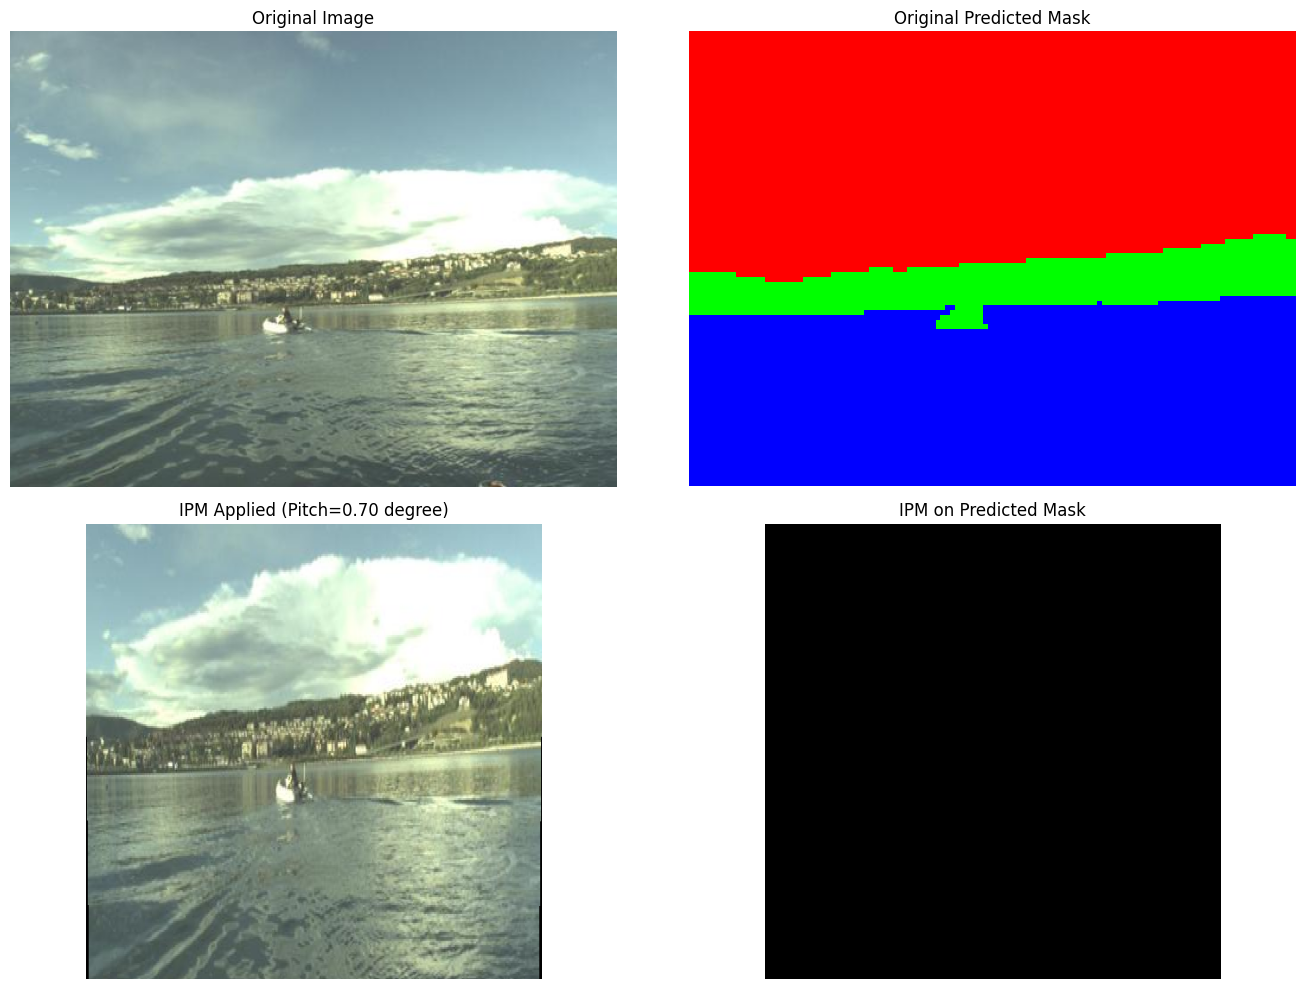

(384, 512, 3)
(96, 128, 3)


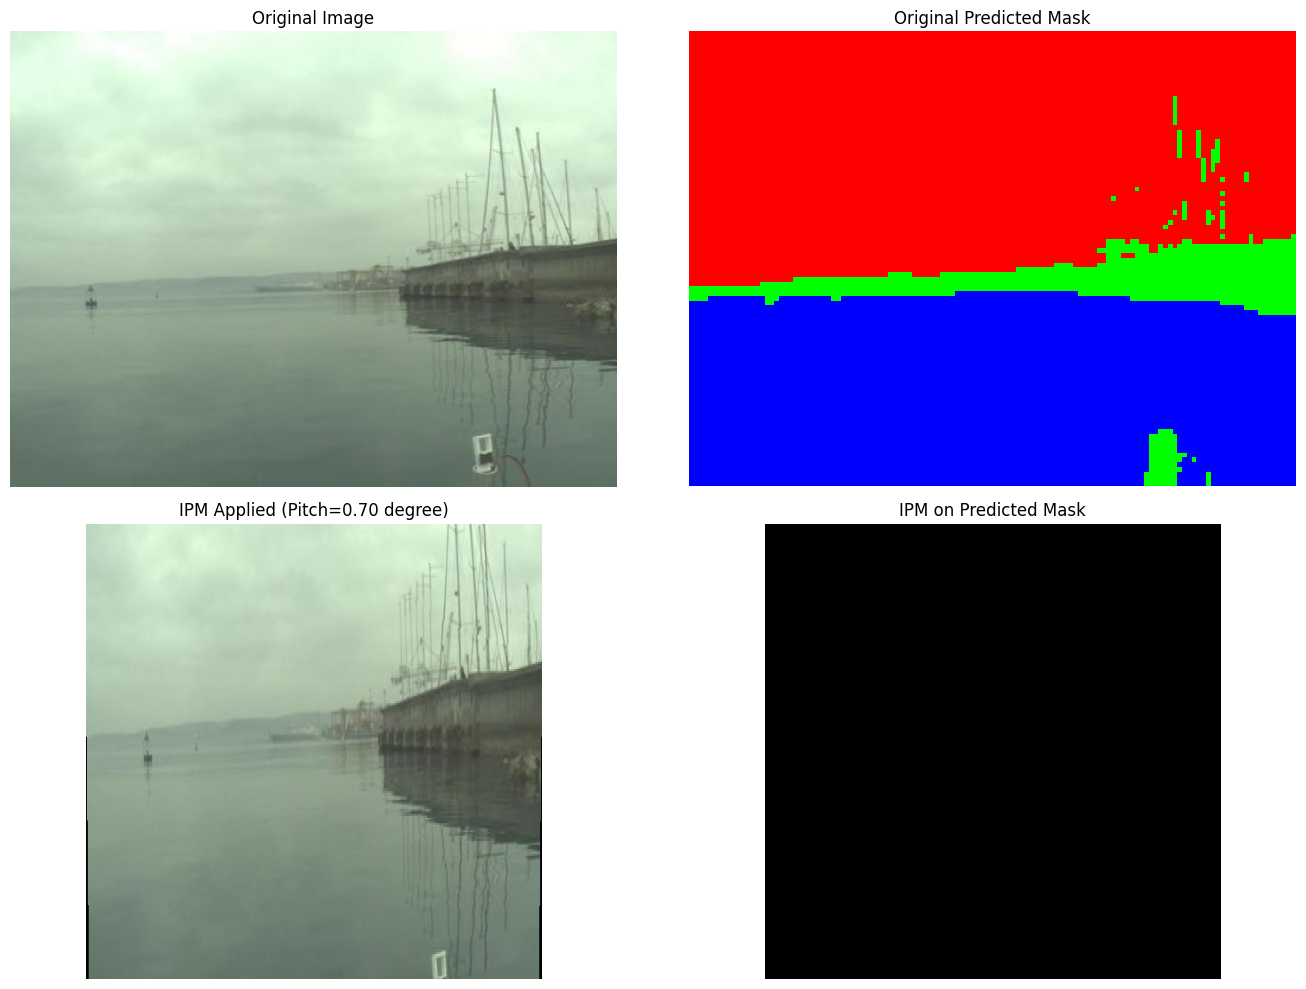

(384, 512, 3)
(96, 128, 3)


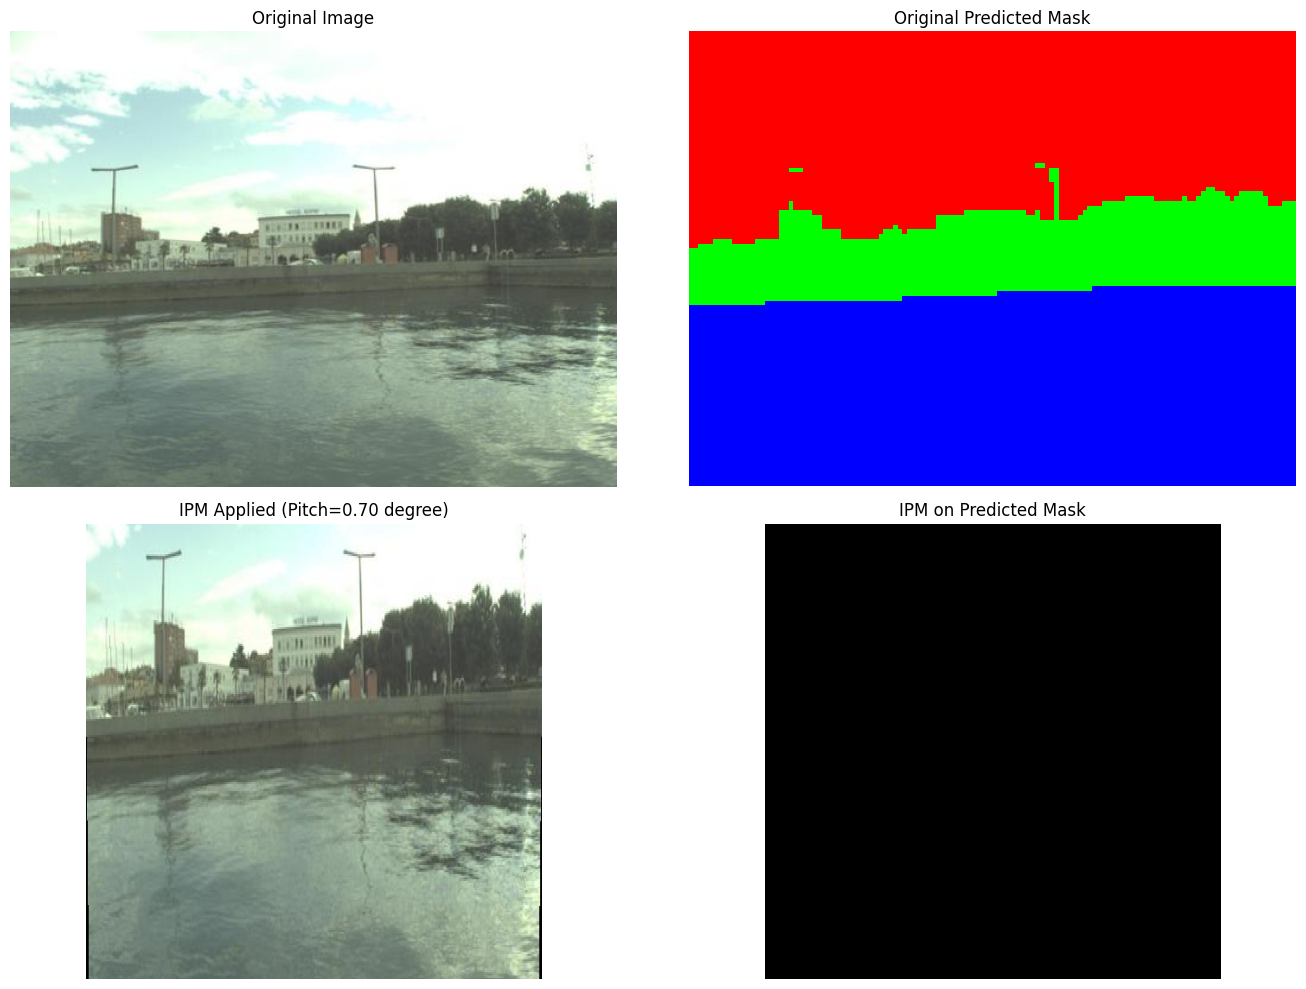

(384, 512, 3)
(96, 128, 3)


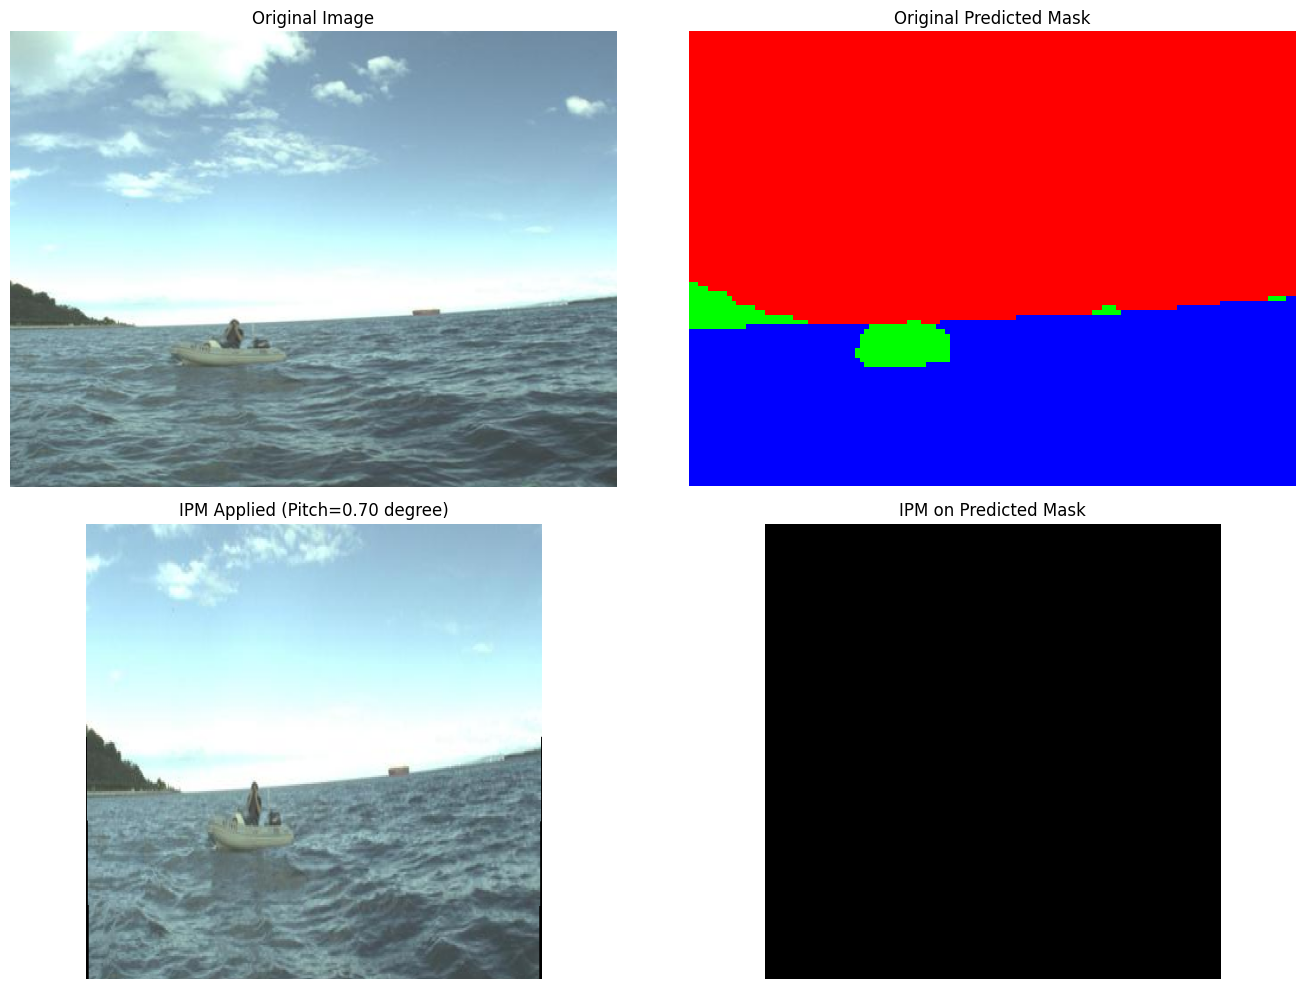

In [18]:
visualize_dataset_with_ipm(
    dataset=ds,
    pred_masks=pred_masks,
    num_samples=4,
    split_name="val",
    color_map=color_map
)